# Data Analysis of Road Traffic Data

## Analysing Delay Hours

In [1]:
#installing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib import cm
import seaborn as sns
from collections import Counter
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

### Analysing Hourly Data

PAWS_DBT_RPT.MART_ADDINSIGHT_FCT_LINK_AGG_1H table was used for the dataset. The initial pre-processing to extract data for only the links common in 2023 and 2024 was done in Snowflake.

In [2]:
#loading the dataset
df_1hour = pd.read_csv('1hour_common Link.csv')
df_1hour.head()

,COMPOSITE_KEY,START_DATE_KEY,WEEK_DAY,START_TIME_KEY,TRAVEL_TIME,DELAY,CONGESTION,BASELINE_TRAVEL_TIME,BASELINE_DELAY,BASELINE_SPEED,BASELINE_EXCESS_DELAY,BASELINE_CONGESTION
0,3ac57d2c754b33a66804ce77dfb8b824,20230620,2,25201,75.333333,20.333333,0.083333,74.741098,16.160611,24.548653,-8.141848,0.119875
1,14ac3cc15a045b467b62ce4fafdaf84e,20230620,2,21601,121.583333,12.583333,0.083333,127.990476,13.971429,49.992857,-12.876190,0.126190
2,68d17858e35fecd0ec69cc767ec7a76a,20230620,2,43201,87.416667,3.416667,0.000000,88.453704,2.784722,93.761574,0.467593,0.138889
3,90746c5040cb0d0c15010f5179ab016f,20230620,2,21601,54.833333,17.833333,0.000000,53.906016,15.060936,27.647074,-0.054477,0.360567
4,9ab5ca8f6befa5fd39e0c23cdd3b2a14,20230620,2,72001,81.166667,34.166667,0.000000,50.817723,14.092449,43.442045,2.087250,0.594681


#### Data Cleaning

##### 1. Removing Null Values

In [3]:
df_1hour = df_1hour.dropna(subset=['TRAVEL_TIME', 'DELAY','CONGESTION','BASELINE_EXCESS_DELAY','BASELINE_CONGESTION'])

##### 2. Converting 'START_DATE' to datetime and all time related columns to hours.

In [4]:
# Function to convert seconds into HH:MM format
def convert_seconds_to_time(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, _ = divmod(remainder, 60)
    return f"{int(hours):02}:{int(minutes):02}"

# Apply the function to convert START_TIME_KEY to readable time
df_1hour['START_TIME_FORM'] = df_1hour['START_TIME_KEY'].apply(convert_seconds_to_time)
# Convert the START_DATE_KEY to datetime format
df_1hour['START_DATE'] = pd.to_datetime(df_1hour['START_DATE_KEY'], format='%Y%m%d')
#Convert Travel Time to hours
df_1hour['TRAVEL_TIME_HOURS'] = df_1hour['TRAVEL_TIME'] / 3600
# Convert DELAY from seconds to hours
df_1hour['DELAY_HOURS'] = df_1hour['DELAY'] / 3600

##### 3. Converting WEEK_DAY to get name the day name

In [5]:
import calendar

# Create a new column for the day of the week
df_1hour['WEEK_DAY_NAME'] = df_1hour['WEEK_DAY'].apply(lambda x: calendar.day_name[x-1])

df_1hour.head()

,COMPOSITE_KEY,START_DATE_KEY,WEEK_DAY,START_TIME_KEY,TRAVEL_TIME,DELAY,CONGESTION,BASELINE_TRAVEL_TIME,BASELINE_DELAY,BASELINE_SPEED,BASELINE_EXCESS_DELAY,BASELINE_CONGESTION,START_TIME_FORM,START_DATE,TRAVEL_TIME_HOURS,DELAY_HOURS,WEEK_DAY_NAME
0,3ac57d2c754b33a66804ce77dfb8b824,20230620,2,25201,75.333333,20.333333,0.083333,74.741098,16.160611,24.548653,-8.141848,0.119875,07:00,2023-06-20,0.020926,0.005648,Tuesday
1,14ac3cc15a045b467b62ce4fafdaf84e,20230620,2,21601,121.583333,12.583333,0.083333,127.990476,13.971429,49.992857,-12.876190,0.126190,06:00,2023-06-20,0.033773,0.003495,Tuesday
2,68d17858e35fecd0ec69cc767ec7a76a,20230620,2,43201,87.416667,3.416667,0.000000,88.453704,2.784722,93.761574,0.467593,0.138889,12:00,2023-06-20,0.024282,0.000949,Tuesday
3,90746c5040cb0d0c15010f5179ab016f,20230620,2,21601,54.833333,17.833333,0.000000,53.906016,15.060936,27.647074,-0.054477,0.360567,06:00,2023-06-20,0.015231,0.004954,Tuesday
4,9ab5ca8f6befa5fd39e0c23cdd3b2a14,20230620,2,72001,81.166667,34.166667,0.000000,50.817723,14.092449,43.442045,2.087250,0.594681,20:00,2023-06-20,0.022546,0.009491,Tuesday


##### 4. Splitting the dataset for 2023 and 2024 from June to September

In [6]:
data_2023 = df_1hour[(df_1hour['START_DATE'] >='2023-06-01') & (df_1hour['START_DATE'] <= '2023-09-17')]
data_2024 = df_1hour[(df_1hour['START_DATE'] >='2024-06-01') & (df_1hour['START_DATE'] <= '2024-09-17')]

#### Comparing Delay by Month

/var/folders/_4/gs_29qcj0rz_nm8qy011rh_m0000gn/T/ipykernel_53781/2371920445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['Month'] = data_2024['START_DATE'].dt.to_period('M').dt.strftime('%Y, %B')


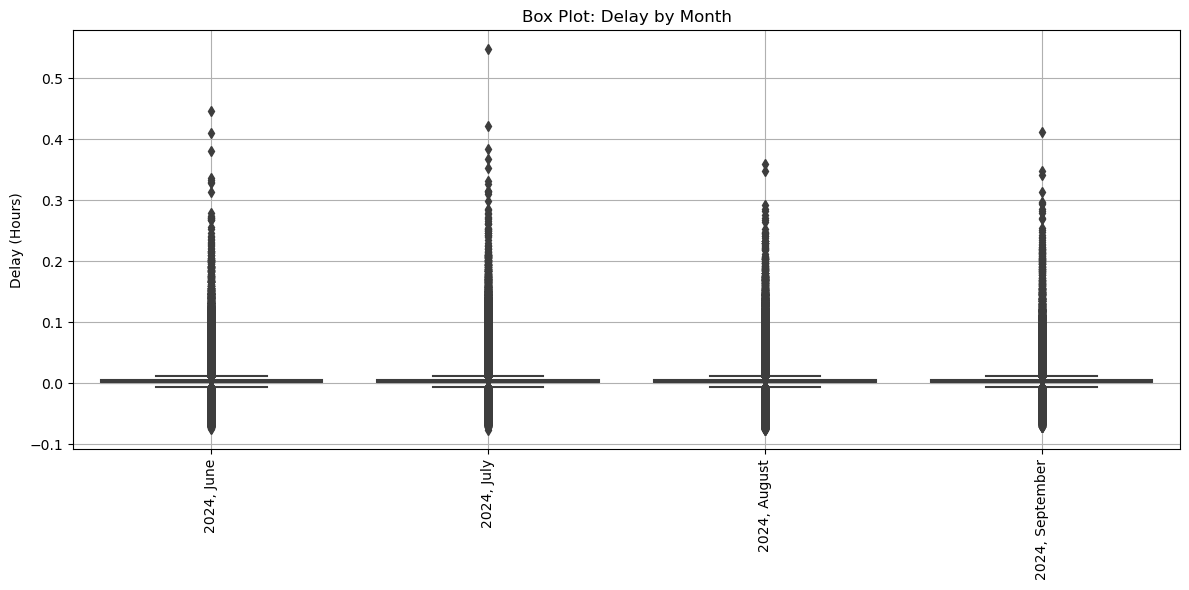

In [7]:
# Extract month from START_DATE
data_2024['Month'] = data_2024['START_DATE'].dt.to_period('M').dt.strftime('%Y, %B')

# Define the correct order for months
month_order = ['2024, June', '2024, July', '2024, August', '2024, September']

# Create a box plot of delay by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='DELAY_HOURS', data=data_2024, order=month_order)
plt.title('Box Plot: Delay by Month')
plt.xlabel('')
plt.ylabel('Delay (Hours)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Observation: ##### 

1. The box plot shows that the delays are roughly consistent across all months (outliers excepted).
2. They are concentrated between 0.0 to 0.05 indicating around 3 minutes delay on average.
3. It can also be seen that the number of outliers for August and September are lesser compared to June and July.
4. Negative delays indicate early arrival.

Overall, the conditions are stable.

The time has been segmented into seven categories, as outlined below:

1. **6AM - 8AM:** Early Morning Traffic
2. **8AM - 10AM:** Morning Peak
3. **10AM - 3PM:** Midday Traffic
4. **3PM - 6PM:** Evening Peak
5. **6PM - 8PM:** Late Evening Traffic
6. **8PM - 12AM:** Night Traffic
7. **12AM - 6AM:** Night/Early Morning Traffic

/var/folders/_4/gs_29qcj0rz_nm8qy011rh_m0000gn/T/ipykernel_53781/1765477942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['START_TIME_FORM'] = pd.to_datetime(data_2024['START_TIME_FORM'], format='%H:%M:%S', errors='coerce').fillna(pd.to_datetime(data_2024['START_TIME_FORM'], format='%H:%M', errors='coerce')).dt.hour
/var/folders/_4/gs_29qcj0rz_nm8qy011rh_m0000gn/T/ipykernel_53781/1765477942.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2024['Categorise Traffic Time'] = data_2024[

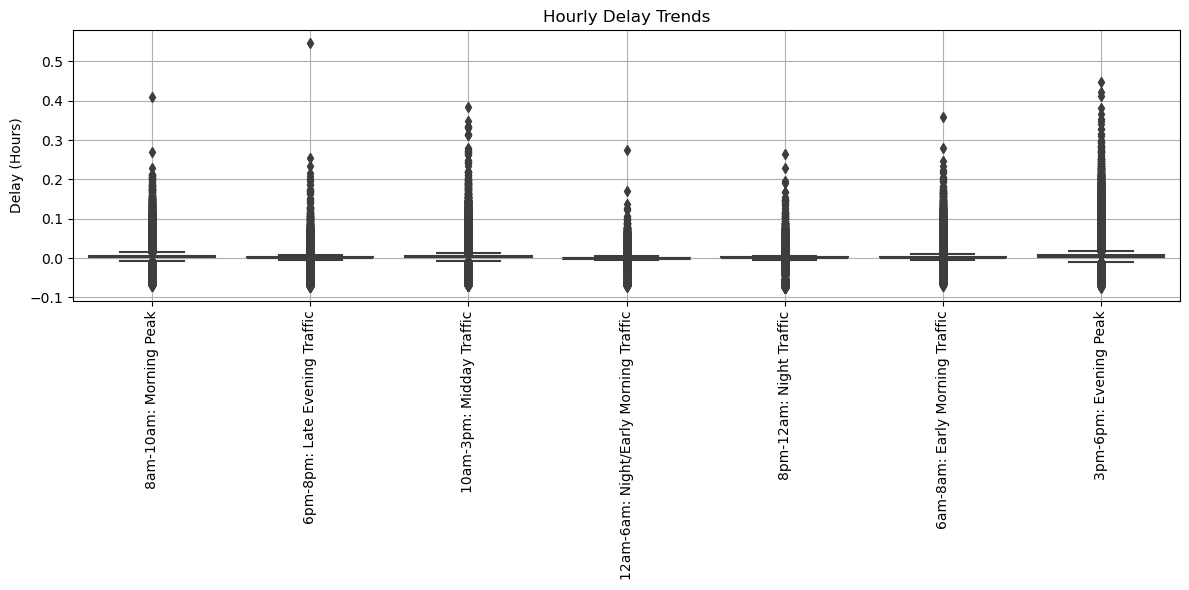

In [8]:
# Handle the case where START_TIME_FORM is  "HH:MM:SS" 
data_2024['START_TIME_FORM'] = pd.to_datetime(data_2024['START_TIME_FORM'], format='%H:%M:%S', errors='coerce').fillna(pd.to_datetime(data_2024['START_TIME_FORM'], format='%H:%M', errors='coerce')).dt.hour

# Define the function for categorizing times based on business hours
def categorise_traffic_time(hour):
    if 8 <= hour < 10:
        return '8am-10am: Morning Peak'
    elif 15 <= hour < 18:
        return '3pm-6pm: Evening Peak'
    elif 10 <= hour < 15:
        return '10am-3pm: Midday Traffic'
    elif 18 <= hour < 20:
        return '6pm-8pm: Late Evening Traffic'
    elif 0 <= hour < 6:
        return '12am-6am: Night/Early Morning Traffic'
    elif 6 <= hour < 8:
        return '6am-8am: Early Morning Traffic'
    else:
        return '8pm-12am: Night Traffic'

data_2024['Categorise Traffic Time'] = data_2024['START_TIME_FORM'].apply(categorise_traffic_time)

# Plot 
plt.figure(figsize=(12, 6))
sns.boxplot(x='Categorise Traffic Time', y='DELAY_HOURS', data=data_2024)
plt.title('Hourly Delay Trends')
plt.xlabel('')
plt.ylabel('Delay (Hours)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Observation: #####
1. Peak Hours (Morning and Evening): Delays are highest during the morning (8 am-10 am) and evening peak (3 pm-6 pm) hours. Outliers in both time periods show delays that occasionally spike above 0.4 hours. The wider spread of data points during these times reflects more congestion.
2. Off-Peak Hours (Midday, Late Evening, Night): During off-peak hours such as midday, late evening, and night traffic, delays are minimal, with most values concentrated near 0.
3. Night/Early Morning Traffic: Delays are virtually non-existent during the night and early morning (12 am-6 am), reflecting smooth traffic flow during these hours.

Now, doing the same for 2023

/var/folders/_4/gs_29qcj0rz_nm8qy011rh_m0000gn/T/ipykernel_53781/3802632082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2023['Month'] = data_2023['START_DATE'].dt.to_period('M').dt.strftime('%Y, %B')


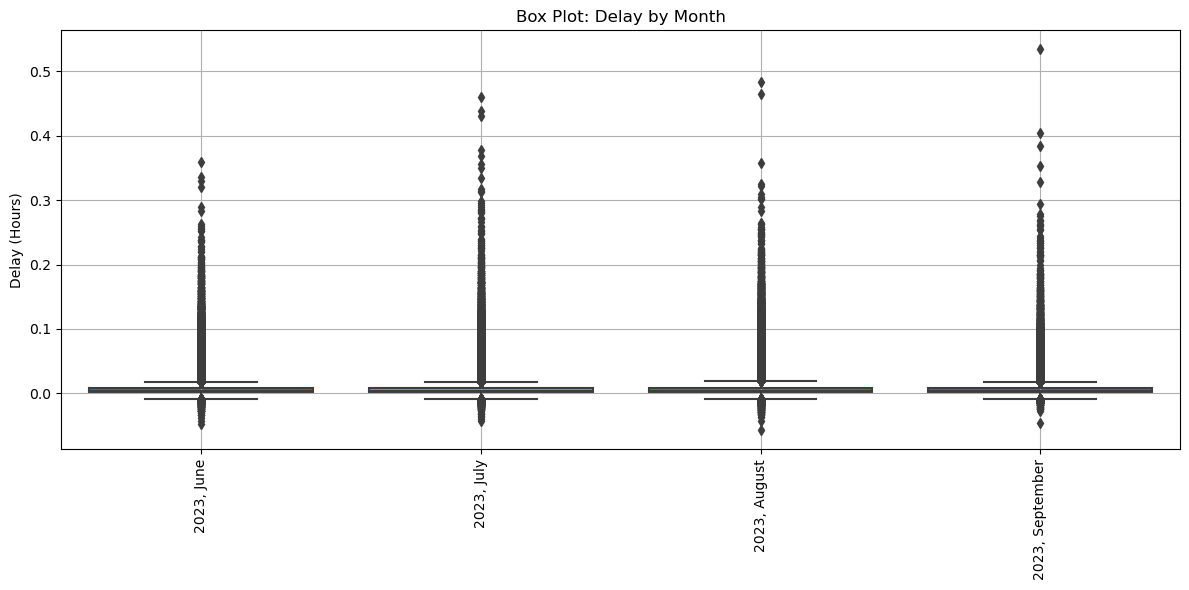

In [9]:
# Extract month from START_DATE
data_2023['Month'] = data_2023['START_DATE'].dt.to_period('M').dt.strftime('%Y, %B')

# Define the correct order for months
month_order_2 = ['2023, June', '2023, July', '2023, August', '2023, September']

# Create a box plot of delay by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='DELAY_HOURS', data=data_2023, order=month_order_2)
plt.title('Box Plot: Delay by Month')
plt.xlabel('')
plt.ylabel('Delay (Hours)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Observation: #####

1. The box plot shows that the delays are roughly consistent across all months (outliers excepted).
2. They are concentrated between 0.0 to 0.05 indicating around 3 minutes delay on average.
3. It can also be seen that the spread of outliers increases from June to September.
4. From July to September, the number of outliers are reducing (frequency) but the delays are more significant.
5. Negative delays indicate early arrival.

/var/folders/_4/gs_29qcj0rz_nm8qy011rh_m0000gn/T/ipykernel_53781/4133546809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2023['START_TIME_FORM'] = pd.to_datetime(data_2023['START_TIME_FORM'], format='%H:%M:%S', errors='coerce').fillna(pd.to_datetime(data_2023['START_TIME_FORM'], format='%H:%M', errors='coerce')).dt.hour
/var/folders/_4/gs_29qcj0rz_nm8qy011rh_m0000gn/T/ipykernel_53781/4133546809.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2023['Categorise Traffic Time'] = data_2023['

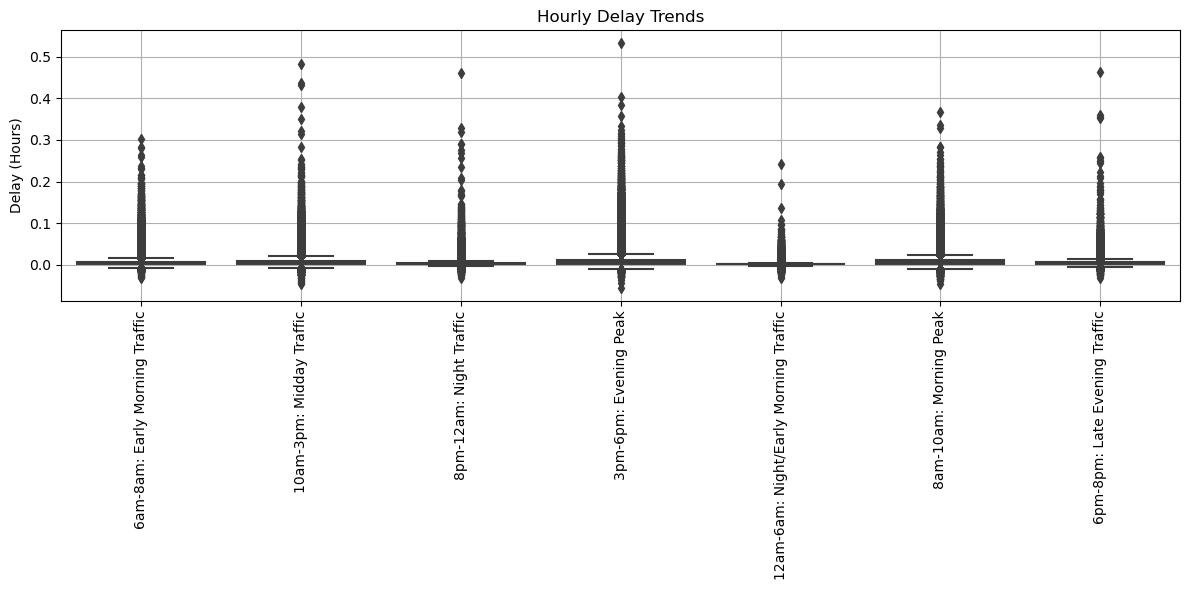

In [10]:
# Handle the case where START_TIME_FORM is  "HH:MM:SS" 
data_2023['START_TIME_FORM'] = pd.to_datetime(data_2023['START_TIME_FORM'], format='%H:%M:%S', errors='coerce').fillna(pd.to_datetime(data_2023['START_TIME_FORM'], format='%H:%M', errors='coerce')).dt.hour

data_2023['Categorise Traffic Time'] = data_2023['START_TIME_FORM'].apply(categorise_traffic_time)

# Plot 
plt.figure(figsize=(12, 6))
sns.boxplot(x='Categorise Traffic Time', y='DELAY_HOURS', data=data_2023)
plt.title('Hourly Delay Trends')
plt.xlabel('')
plt.ylabel('Delay (Hours)')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

##### Observation: #####
1. Peak Traffic Hours: The evening peak (3 pm-6 pm) and morning peak (8 am-10 am) are where the most delays occur, with more significant outliers indicating congestion.
2. Off-Peak Hours: The early morning (6 am-8 am) and late evening (6 pm-8 pm) traffic exhibit smooth flow with minimal delays. Similarly, the night/early morning traffic (12 am-6 am) is relatively free of disruptions.
3. Midday and Night Traffic: Midday (10 am-3 pm) and night traffic (8 pm-12 am) have some delays, but the spread remains limited, suggesting moderate levels of congestion during these hours.

### Comparing 2024 with 2023 ###

#### Observations: ####
1. **Median Delays**: 
   - In **2023**, there was a clear upward trend in the median delays from June to September, indicating a progressive increase in congestion as the year advanced.
   - In **2024**, the median delays remained relatively consistent across all four months, showing only minor fluctuations. This suggests more stable traffic patterns and potentially better traffic flow management compared to 2023.

2. **Variability in Delays**:
   - In **2023**, the variability in delays, as shown by the interquartile range (IQR), increased from June to September, with September having the largest spread. This indicates that September experienced the highest traffic inconsistency and congestion.
   - In **2024**, the variability was more balanced across all months, with smaller fluctuations in both the IQR and the number of outliers. This suggests a more controlled and consistent traffic flow throughout the year.

3. **Outliers (Extreme Delays)**:
   - **2023** saw a sharp increase in outliers, particularly in September, indicating more frequent extreme delays.
   - In **2024**, there was a noticeable reduction in the number of outliers, especially in the later months, suggesting fewer instances of severe traffic delays and a more predictable travel experience overall.

4. **Negative Delays (Faster Travel Times)**:
   - The occurrence of **negative delays** (indicating faster-than-expected travel times) was higher in **August and September 2024** compared to the same months in 2023. This points to reduced travel times and improved traffic conditions in 2024.

5. **Hourly Trends**:
   - Similarly, in the **hourly delay trends** for 2024, the proportion of negative delays was higher compared to 2023, especially during peak times. This implies that congestion during peak hours was less intense in 2024, with some routes even experiencing faster travel times than anticipated.

#### Conclusion: ####
Both years experienced traffic delays, but the nature of these delays differed significantly. In **2023**, delays were more variable and pronounced, especially during the month of September, which had the highest levels of congestion and outliers. In contrast, **2024** showed more evenly distributed delays across all months, with fewer extreme cases and more frequent instances of faster travel times. 

The increase in **negative delays** during peak times and the months of **August and September 2024** suggests an overall reduction in congestion, possibly influenced by initiatives like the **50c Public Transport Fare**. This change could have encouraged a shift to public transport, thereby easing traffic on the roads and reducing delays.

***

In [11]:
#Adding the time categories to original dataset to use it for training the model
# Extract month from START_DATE
df = df_1hour
df['Month'] = df['START_DATE'].dt.to_period('M').dt.strftime('%Y, %B')

In [12]:
df['START_TIME_FORM'] = pd.to_datetime(df['START_TIME_FORM'], format='%H:%M:%S', errors='coerce').fillna(pd.to_datetime(df['START_TIME_FORM'], format='%H:%M', errors='coerce')).dt.hour

df['Categorise Traffic Time'] = df['START_TIME_FORM'].apply(categorise_traffic_time)

#### Actual Morning Peak

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

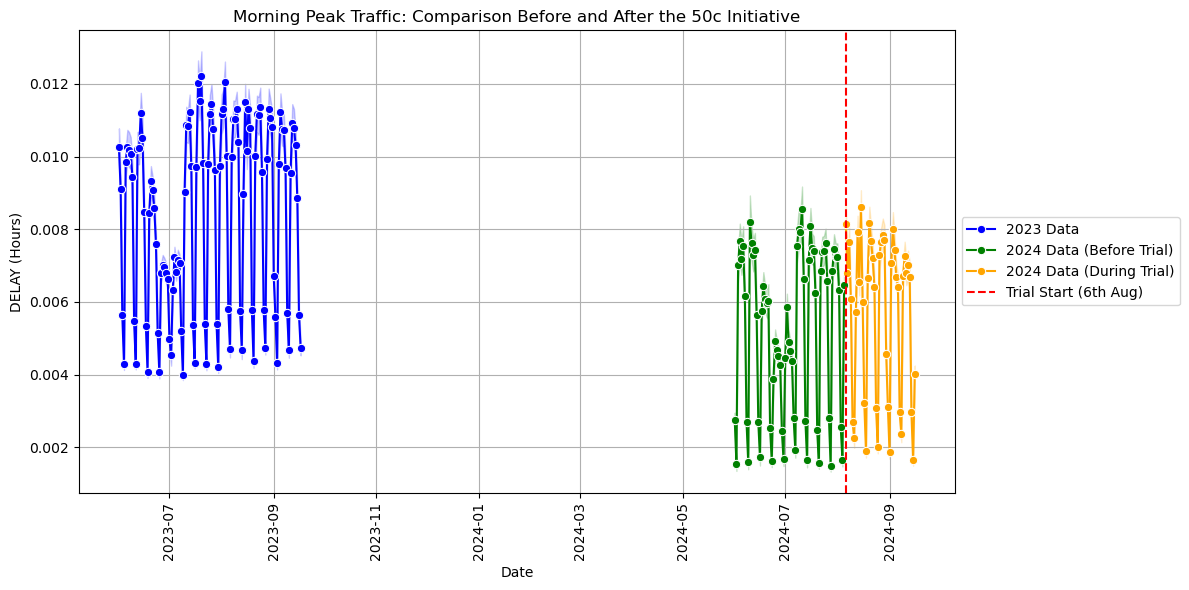

In [13]:
# Filter the dataset to include only '8am-10am: Morning Peak' for 2023 and 2024
df_2023_morning = data_2023[data_2023['Categorise Traffic Time'] == '8am-10am: Morning Peak']
df_2024_morning = data_2024[data_2024['Categorise Traffic Time'] == '8am-10am: Morning Peak']

# Define the dates for trial start (6th Aug 2024) and pre-trial data range
trial_start_date = '2024-08-06'

# Split the 2024 data into "before" and "during" the 50c initiative
df_2024_before_trial = df_2024_morning[df_2024_morning['START_DATE'] < trial_start_date]
df_2024_during_trial = df_2024_morning[df_2024_morning['START_DATE'] >= trial_start_date]

# Plot the full Morning Peak data for 2023 and 2024
plt.figure(figsize=(12, 6))

# Plot for 2023 Morning Peak
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_2023_morning, marker="o", label='2023 Data', color='blue')

# Plot for 2024 Morning Peak (before trial)
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_2024_before_trial, marker="o", label='2024 Data (Before Trial)', color='green')

# Plot for 2024 Morning Peak (during trial)
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_2024_during_trial, marker="o", label='2024 Data (During Trial)', color='orange')

# Add a vertical red dashed line to mark the start of the trial
highlight_date = pd.to_datetime('2024-08-06')
plt.axvline(x=highlight_date, color='red', linestyle='--', label='Trial Start (6th Aug)')

# Customise the plot
plt.title('Morning Peak Traffic: Comparison Before and After the 50c Initiative')
plt.xlabel('Date')
plt.ylabel('DELAY (Hours)')
plt.xticks(rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.tight_layout()
plt.show()

##### Observation: #####
1. **Pronounced Peaks in 2023:** The 2023 data shows significantly more frequent and higher peaks in traffic delays, especially in July and August. Delays often rise to values between 0.010 to 0.012 hours, indicating heavier congestion during several days in the morning peak hours.
   
2. **Lower Delays in 2024:** In 2024, the delays are generally lower, with most values staying below 0.010 hours. There is a notable reduction in fluctuation compared to 2023, and the peaks are much less pronounced, suggesting an improvement in traffic conditions.
   
3. **Consistency in 2024:** The delays in 2024 appear more consistent and smoother, with fewer significant spikes. This stability indicates that traffic conditions were more predictable and stable during the Morning Peak hours in 2024 compared to 2023.

4. **Pre-Trial Period (June 1 - August 5, 2024):** Traffic delays before the 50c initiative (June to early August 2024) were already lower compared to the same period in 2023, showing improved traffic flow during this period.

5. **Effect of the 50c Initiative (Post-August 6, 2024):** After the introduction of the 50c fare trial, the delays stabilized even further, with no significant spikes. The pattern of delays becomes even more consistent, with a slight reduction in overall delay levels compared to both the pre-trial period in 2024 and the corresponding period in 2023.

6. **Weekday vs Weekend Influence:** The fluctuating peaks that are still visible in both 2023 and 2024 may reflect differences between weekday and weekend traffic patterns. However, these peaks are more pronounced in 2023.

**Conclusion:** 
While both 2023 and 2024 follow similar patterns in terms of overall delay trends, 2024 consistently exhibits lower traffic delays. The introduction of the **50c fare initiative** seems to have played a role in further reducing and stabilizing traffic delays, suggesting that the initiative positively impacted reducing congestion, particularly during the Morning Peak hours.

#### Actual Evening Peak

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

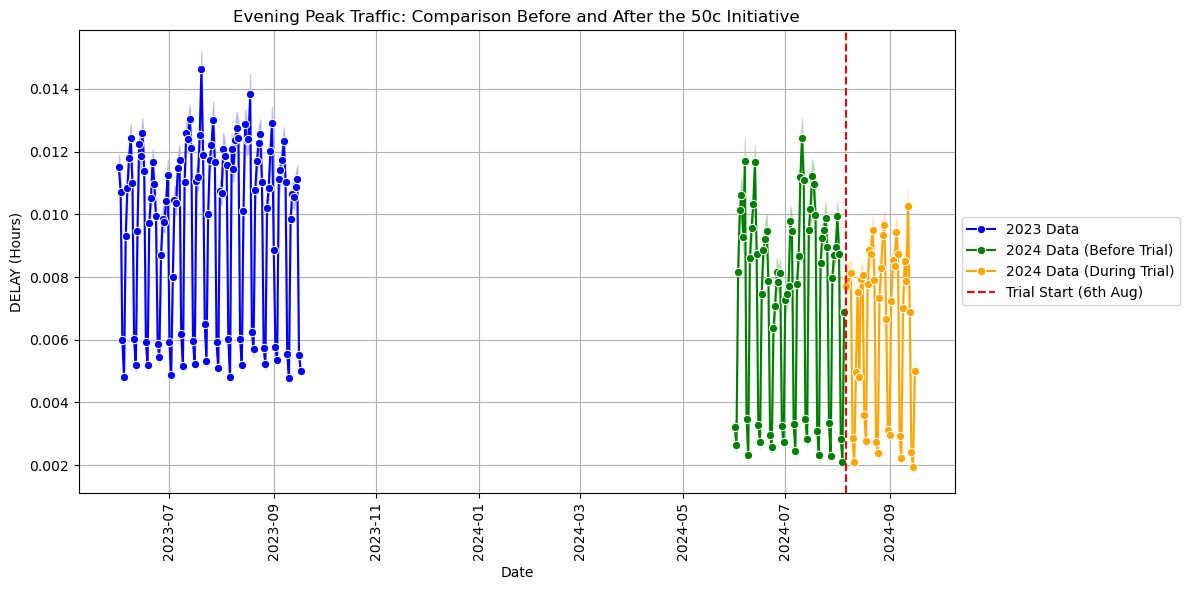

In [19]:
# Assuming 'data_2023' and 'data_2024' are your dataframes with START_DATE and DELAY_HOURS columns
# And 'Categorise Traffic Time' column contains '3pm-6pm: Evening Peak'

# Filter the dataset for '3pm-6pm: Evening Peak'
df_2023_evening = data_2023[data_2023['Categorise Traffic Time'] == '3pm-6pm: Evening Peak']
df_2024_evening = data_2024[data_2024['Categorise Traffic Time'] == '3pm-6pm: Evening Peak']

# Split 2024 data into before and during the trial periods
df_2024_before_trial = df_2024_evening[(df_2024_evening['START_DATE'] >= '2024-06-01') & (df_2024_evening['START_DATE'] <= '2024-08-05')]
df_2024_during_trial = df_2024_evening[(df_2024_evening['START_DATE'] >= '2024-08-06') & (df_2024_evening['START_DATE'] <= '2024-09-16')]

# Plotting
plt.figure(figsize=(12, 6))

# 2023 data
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_2023_evening, marker="o", label='2023 Data', color='blue')

# 2024 before the trial
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_2024_before_trial, marker="o", label='2024 Data (Before Trial)', color='green')

# 2024 during the trial
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_2024_during_trial, marker="o", label='2024 Data (During Trial)', color='orange')

# Add a vertical red line at the trial start date (6th August)
highlight_date = pd.to_datetime('2024-08-06')
plt.axvline(x=highlight_date, color='red', linestyle='--', label='Trial Start (6th Aug)')

# Customise the plot
plt.title('Evening Peak Traffic: Comparison Before and After the 50c Initiative')
plt.xlabel('Date')
plt.ylabel('DELAY (Hours)')
plt.xticks(rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.tight_layout()
plt.show()

##### Observation: #####
1. **2023 Data**: Delays during the Evening Peak in 2023 show frequent peaks, with consistent delays around 0.012 hours throughout July and August, indicating more pronounced traffic congestion.
   
2. **2024 Data (Before Trial)**: In the pre-trial period (June to August 5, 2024), delays are notably lower compared to the same period in 2023. The peaks are less frequent and less severe, suggesting improved traffic conditions before the 50c fare initiative.

3. **2024 Data (During Trial)**: Following the start of the trial on August 6, there is a clear reduction in the magnitude of delays. The overall trend from August to September shows fewer pronounced peaks and more consistent, stabilized delays, indicating further improvements in traffic conditions during the trial period.

#### Conclusion: ####
The 50c fare trial appears to have contributed significantly to reducing traffic delays during the Evening Peak. Both the frequency and magnitude of delays have decreased post-trial, with traffic patterns becoming more stable and consistent compared to both the pre-trial months in 2024 and the same period in 2023. This suggests that the trial has successfully encouraged greater public transport use, helping alleviate road congestion and improving overall traffic flow.

<hr style="border: none; border-top: 1px dotted black;">

### Prediction using Linear Regression

##### Things to note: #####
1. We need to filter the dataset to include only the Peak traffic times for the years 2023 and 2024. We'll break this down into training (pre-August 2024) and test (post-August 2024) sets.
2. In this case, since we are predicting over time, our main feature will be time (likely as ordinal date values) and the target variable will be delay in hours.
3. We should ensure there are no missing values or outliers in the dataset, as these can affect the accuracy of the model.
4. We'll use Simple Linear Regression to model the relationship between time (as the independent variable) and delay (hours) (as the dependent variable).
5. We'll use the trained model to predict the delays for August to December 2024. This will give us insight into whether delays are expected to increase or decrease, and how they trend after the 50c fare initiative.
6. We'll visualize both the actual data (June-September) and the predicted data (October-December) in the same plot, highlighting any noticeable trends.
7. We want to observe whether the delay is expected to decrease due to the 50c initiative (which might lead to reduced road traffic and less congestion). We'll also need to evaluate if the predicted delay will eventually stagnate after a certain point, indicating the limit of the 50c fare's impact on congestion reduction.

##### Possible Approaches: #####

| **Approach**                                | **Training Data**                 | **Testing Data**         | **Pros**                                                                                                                                               | **Cons**                                                                                                                                                    |
|---------------------------------------------|-----------------------------------|--------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1. Use 2023 data only                       | All of 2023                      | August-September 2024    | - Model learns full seasonality of an entire year. <br> - Good baseline from previous year.                                                            | - Model may not capture new traffic dynamics in 2024. <br> - Could underperform if 2024 traffic patterns differ significantly from 2023.                    |
| 2. Use June-July 2024 only                  | June-July 2024                   | August-September 2024    | - Recent and relevant data, reflective of current traffic trends. <br> - Focused on pre-trial 2024 behavior.                                            | - Misses out on yearly seasonality trends from 2023. <br> - Model may overfit to two months of limited data.                                                 |
| 3. Use 2023 + June-July 2024 (proposed)     | All of 2023 + June-July 2024      | August-September 2024    | - Captures full year seasonality from 2023.<br> - Includes recent pre-trial 2024 data.<br> - Balanced and likely to generalize well.                    | - Potential challenge if post-trial behavior is very different. <br> - Limited 2024 data for training (only two months).                                     |
| 4. Use all of 2024 (June-September)         | June-July + August-September 2024 | None                     | - Focused entirely on recent data.<br> - No need for testing; predictions are real-time.                                                                | - Model may not learn broader patterns or seasonality.<br> - Predictions cannot be verified since there’s no test set.                                       |
| 5. Mixed year approach                      | June-August 2023 + June-July 2024 | August-September 2024    | - Combines data from two years (2023 + 2024) in similar time periods.<br> - Provides a balanced comparison of before and after patterns.                | - Mixing two different years may confuse the model if the traffic behavior changes year-to-year.<br> - Less exposure to full seasonality.                   |


We will be using the proposed approach from the table above as it offers an optimal balance between capturing the seasonal trends from the previous year and incorporating the most recent data leading up to the 50c trial. This method ensures robustness by leveraging historical patterns while avoiding data leakage, as the post-trial period is kept exclusively for testing.

#### Linear Regression on Morning Peak

/var/folders/_4/gs_29qcj0rz_nm8qy011rh_m0000gn/T/ipykernel_61495/3262365083.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['START_DATE_ORD'] = df_train['START_DATE'].map(pd.Timestamp.toordinal)
/var/folders/_4/gs_29qcj0rz_nm8qy011rh_m0000gn/T/ipykernel_61495/3262365083.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['START_DATE_ORD'] = df_test['START_DATE'].map(pd.Timestamp.toordinal)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have va

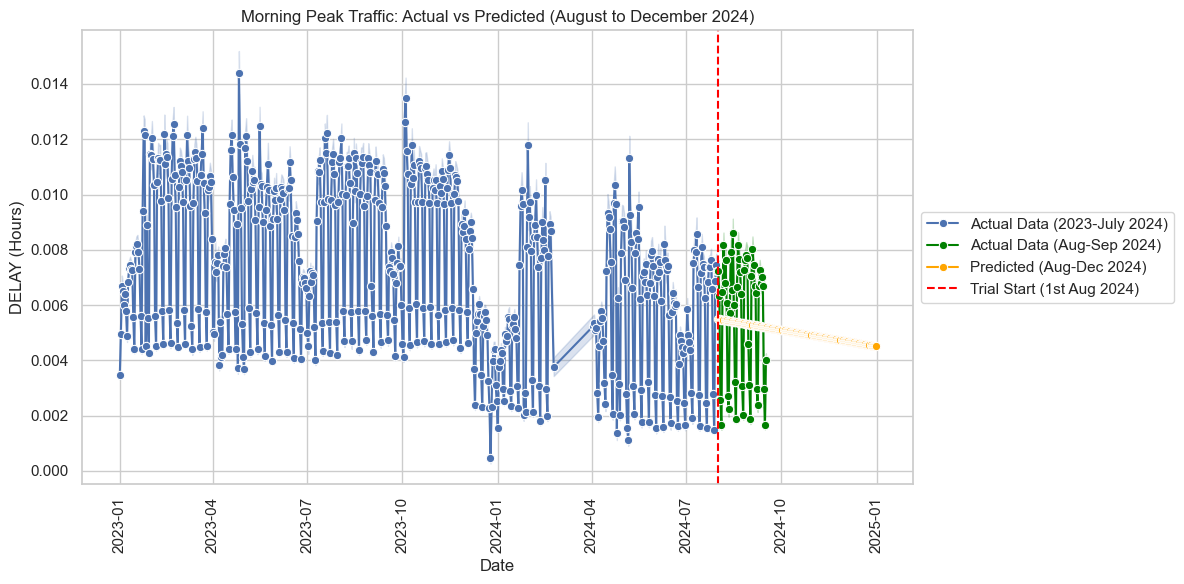

In [21]:
# Filter the dataset to include only '8am-10am: Morning Peak' for 2023 and 2024
df_filtered = df[df['Categorise Traffic Time'] == '8am-10am: Morning Peak']

# Split the data into training and testing sets
# Training set: All 2023 data + 2024 data up to July
df_train = df_filtered[df_filtered['START_DATE'] <= '2024-07-31']

# Testing set: August and September 2024 (for comparison purposes)
df_test = df_filtered[(df_filtered['START_DATE'] >= '2024-08-01') & (df_filtered['START_DATE'] <= '2024-09-30')]

# Convert dates to ordinal for regression
df_train['START_DATE_ORD'] = df_train['START_DATE'].map(pd.Timestamp.toordinal)
df_test['START_DATE_ORD'] = df_test['START_DATE'].map(pd.Timestamp.toordinal)

# Prepare the training data
X_train = df_train[['START_DATE_ORD']]  # Independent variable (ordinal dates)
y_train = df_train['DELAY_HOURS']       # Dependent variable (delay hours)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Prepare the dates for prediction (August to December 2024)
future_dates = pd.date_range(start='2024-08-01', end='2024-12-31')
future_dates_ordinal = future_dates.map(pd.Timestamp.toordinal)

# Predict the delay hours for August to December
X_future = np.array(future_dates_ordinal).reshape(-1, 1)
y_pred = model.predict(X_future)

# Create a DataFrame for the predicted values
df_predictions = pd.DataFrame({
    'START_DATE': future_dates,
    'DELAY_HOURS': y_pred
})

# Set the style for better aesthetics
sns.set(style='whitegrid')

# Plot the actual data (2023-2024) from the training set
plt.figure(figsize=(12, 6))
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_train, marker="o", label='Actual Data (2023-July 2024)')

# Plot the actual data from August and September 2024 (testing set)
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_test, marker="o", color='green', label='Actual Data (Aug-Sep 2024)')

# Plot the predicted values (August to December 2024)
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_predictions, marker="o", color='orange', label='Predicted (Aug-Dec 2024)')

# Add a vertical red line at 01/08/2024
highlight_date = pd.to_datetime('2024-08-01')
plt.axvline(x=highlight_date, color='red', linestyle='--', label='Trial Start (1st Aug 2024)')

# Customise the plot
plt.title('Morning Peak Traffic: Actual vs Predicted (August to December 2024)')
plt.xlabel('Date')
plt.ylabel('DELAY (Hours)')
plt.xticks(rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

##### Observation: #####
1. Initial Decline in Predictions (August - September 2024): The prediction starts relatively close to the actual values recorded in August and September 2024. This suggests that the model has captured the immediate post-trial trend reasonably well. The slight decline in predicted delay hours aligns with the actual data, justifying the model's use of historical data patterns before the trial.
2. Steady Decrease in Delay (October - December 2024): The linear regression model predicts a continuous decrease in traffic delay for the remainder of the year. This steady decline could be attributed to the trend observed in August and September, where delays were lower than in previous months. The model extrapolates this downward trend, likely because the data prior to the trial suggests a significant reduction in delays due to the public transport initiative.

##### Limitation: #####
1. Sharp Gap between Actual and Predicted (From Mid-September Onward): The sharp drop in predicted delays compared to the actual values indicates that the model is forecasting a rapid improvement in traffic conditions. This might be due to the model overfitting the post-trial data, where delays were relatively low, leading to overly optimistic predictions. The continuous downward trend suggests the model expects a significant ongoing impact from the 50c trial on reducing delays, though this could be a limitation of the linear approach.
2. Limitations of the Prediction: The absence of any rebound or stabilization in the delay predictions could indicate a potential flaw in the model's ability to handle real-world variability. Given that traffic patterns can fluctuate due to factors such as holidays, weather, and other external conditions, the linear regression model may not be fully accounting for these dynamics, resulting in predictions that might be overly simplistic.

#### Linear Regression on Evening Peak

/var/folders/_4/gs_29qcj0rz_nm8qy011rh_m0000gn/T/ipykernel_61495/1061341955.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['START_DATE_ORD'] = df_filtered['START_DATE'].map(pd.Timestamp.toordinal)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf

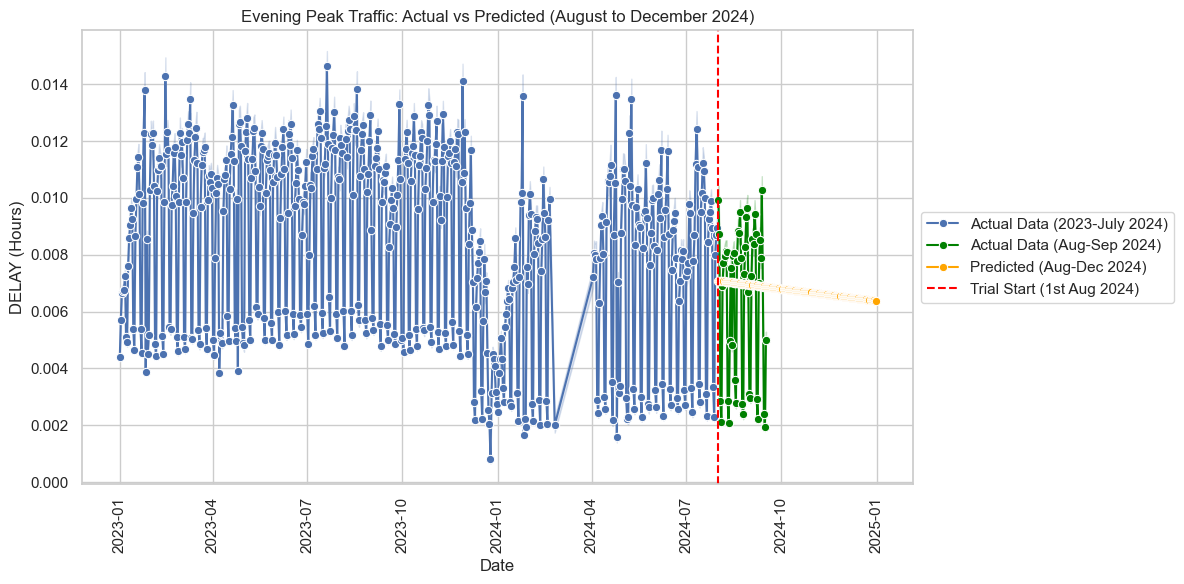

In [22]:
# Filter the dataset to include only '3pm-6pm: Evening Peak' for 2023 and 2024
df_filtered = df[df['Categorise Traffic Time'] == '3pm-6pm: Evening Peak']

# Prepare data for linear regression (Convert dates to ordinal for regression)
df_filtered['START_DATE_ORD'] = df_filtered['START_DATE'].map(pd.Timestamp.toordinal)

# Split the data into training (up to July 2024) and testing (August to September 2024)
df_train = df_filtered[df_filtered['START_DATE'] <= '2024-07-31']
df_test = df_filtered[(df_filtered['START_DATE'] >= '2024-08-01') & (df_filtered['START_DATE'] <= '2024-09-30')]

# Train the linear regression model on training data (up to July 2024)
X_train = df_train[['START_DATE_ORD']]  # Independent variable (ordinal dates)
y_train = df_train['DELAY_HOURS']       # Dependent variable (delay hours)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Prepare the future dates for prediction (August to December 2024)
future_dates = pd.date_range(start='2024-08-01', end='2024-12-31')
future_dates_ordinal = future_dates.map(pd.Timestamp.toordinal)

# Predict the delay hours for August to December
X_future = np.array(future_dates_ordinal).reshape(-1, 1)
y_pred = model.predict(X_future)

# Create a DataFrame for the predicted values
df_predictions = pd.DataFrame({
    'START_DATE': future_dates,
    'DELAY_HOURS': y_pred
})

# Set the style for better aesthetics
sns.set(style='whitegrid')

# Plot the actual data (2023-July 2024)
plt.figure(figsize=(12, 6))
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_filtered[df_filtered['START_DATE'] <= '2024-07-31'], marker="o", label='Actual Data (2023-July 2024)')

# Plot the actual data for August-September 2024
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_test, marker="o", color='green', label='Actual Data (Aug-Sep 2024)')

# Plot the predicted values (August to December 2024)
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_predictions, marker="o", color='orange', label='Predicted (Aug-Dec 2024)')

# Add a vertical red line at 01/08/2024
highlight_date = pd.to_datetime('2024-08-01')
plt.axvline(x=highlight_date, color='red', linestyle='--', label='Trial Start (1st Aug 2024)')

# Customise the plot
plt.title('Evening Peak Traffic: Actual vs Predicted (August to December 2024)')
plt.xlabel('Date')
plt.ylabel('DELAY (Hours)')
plt.xticks(rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

##### Observation: #####
1. Decreasing Trend: The predicted delay hours for the period from August to December 2024 (orange line) show a continuous downward trend, indicating that the model expects traffic delays to reduce steadily over time.

##### Limitations: #####
1. Unlike the actual data (both 2023 and early 2024) which exhibits significant fluctuations and frequent peaks, the predicted values appear smoother. This suggests that the linear regression model is capturing a general trend but might not be as responsive to daily variability in delays.
2. The actual data from August to September 2024 (green line) shows some peaks and fluctuations, which the model has not fully captured in the predictions. The predicted values are consistently lower than the actual delays for this period, suggesting that the model may be underestimating the delays.
3. The model seems to predict an overly optimistic reduction, suggesting that further tuning of the model (or a more complex model) might be necessary to capture the variability better while still forecasting the delay reduction trend.

<hr style="border: none; border-top: 1px dotted black;">

### Prediction using ARIMA

##### Things to note: #####
1. We need to filter the dataset to include only the Peak traffic times for the years 2023 and 2024. We'll break this down into training (pre-August 2024) and test (post-August 2024) sets.
2. Ensure that the data is structured in a time-series format, with time as the index (or converted to ordinal values) and delay (hours) as the dependent variable. ARIMA models work best when the data follows a clear temporal ordering, so we must handle time carefully.
3. If we observe any seasonal trends (e.g., weekly or monthly patterns in traffic delays), we may consider applying SARIMA (Seasonal ARIMA) instead of ARIMA to account for seasonality.
4. ARIMA requires tuning of three key parameters: (p) autoregression order, (d) differencing order, and (q) moving average order. We will use a combination of grid search or statistical criteria like AIC/BIC to find the best set of parameters.
5. Outliers and missing values can significantly affect ARIMA predictions. We need to ensure that the dataset is free of anomalies or handle them appropriately before applying the model.
6. We will analyze the predictions to understand whether traffic delays are expected to reduce or stabilize after the trial. This trend will help evaluate the success of the 50c initiative.
7. We will visualize the actual vs. predicted data to see if ARIMA captures the trend effectively, showing both pre-trial and post-trial delay patterns and predictions up to December.

##### Possible Approaches: #####
| **Approach**                                          | **Description**                                                                 | **Pros**                                                                                         | **Cons**                                                                                          |
|-------------------------------------------------------|---------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------|
| **1. Use Full 2023 and 2024 Data for Training**        | Train the ARIMA model on the entire dataset from 2023 to 2024 (including pre- and post-August 2024). | - Maximizes the amount of data available for training. <br> - Captures both seasonal and trend changes across the entire period. | - Post-August 2024 data may cause data leakage into training. <br> - Harder to generalize predictions. |
| **2. Use Pre-Trial Data for Training (2023 & Jan-July 2024)** (proposed)| Train on data from 2023 and pre-trial 2024 (June to July), and predict August-December 2024.       | - Prevents data leakage. <br> - Focuses on the period before the 50c initiative.                   | - May miss trends or seasonality captured after the 50c trial began.                              |
| **3. Use 2023 Data for Training, Predict 2024**        | Train the ARIMA model only on 2023 data and predict for the entire year of 2024.                   | - No contamination of test data. <br> - Helps understand whether 2023 trends continue into 2024.  | - Ignores recent changes in traffic conditions from 2024.                                         |
| **4. Train on Rolling Window (3-Month Period)**        | Use a rolling window approach, training the model on the last 3 months of data and predicting the next month. | - Captures short-term trends effectively. <br> - Focuses on the most recent data.                | - Requires frequent re-training, computationally expensive. <br> - May miss long-term seasonality. |
| **5. Train on Monthly Aggregates**                     | Train the ARIMA model on monthly aggregated data (monthly averages of delay).                     | - Simplifies the dataset and reduces noise. <br> - Captures seasonality across months.           | - Loss of granularity. <br> - May oversimplify short-term variations in traffic delays.            |


We will be using the proposed ARIMA approach from the table above, as it provides the best balance between capturing seasonal traffic patterns from 2023 and leveraging the most recent data leading up to the 50c fare trial in 2024. This approach ensures a robust model by training solely on pre-trial data, effectively preventing data leakage. By keeping the post-trial period exclusively for testing, we can accurately assess the impact of the 50c initiative on traffic delays, while still utilizing historical trends to inform our predictions.

#### ARIMA on Morning Peak

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/

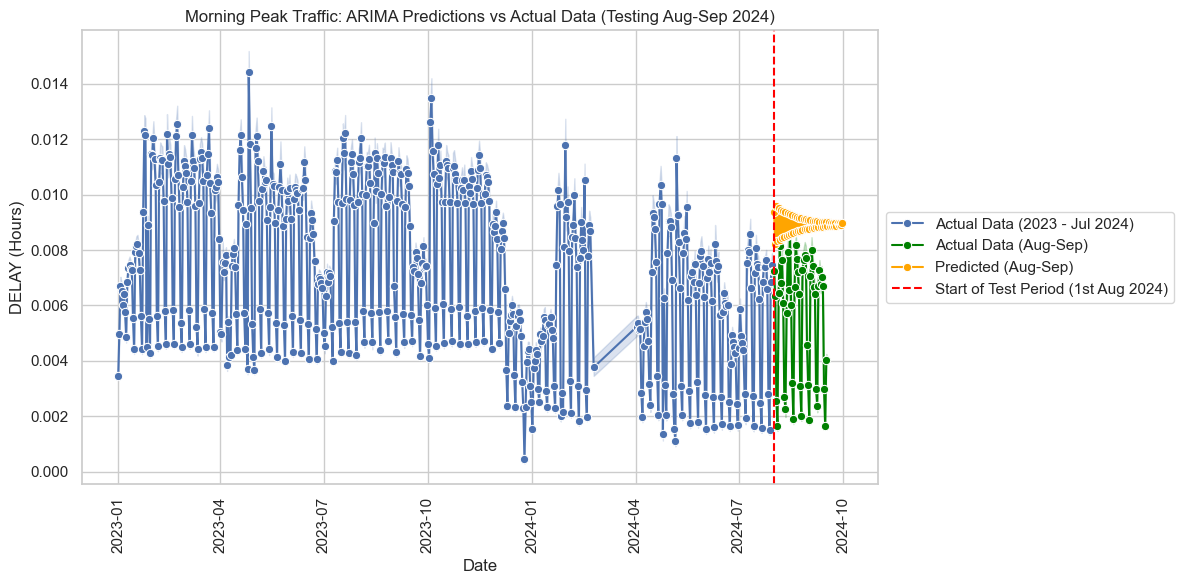

In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

# Step 1: Filter the dataset for '8am-10am: Morning Peak'
df_filtered = df[df['Categorise Traffic Time'] == '8am-10am: Morning Peak'].copy()

# Step 2: Filter the data for training: all data from 2023 to July 2024 (Pre-Trial Data)
df_train = df_filtered[df_filtered['START_DATE'] < '2024-08-01'].copy()

# Convert 'START_DATE' to datetime and set it as the index
df_train['START_DATE'] = pd.to_datetime(df_train['START_DATE'])
df_train.set_index('START_DATE', inplace=True)

# Ensure 'DELAY_HOURS' is numeric and drop NaN values
df_train['DELAY_HOURS'] = pd.to_numeric(df_train['DELAY_HOURS'], errors='coerce')
df_train.dropna(subset=['DELAY_HOURS'], inplace=True)

# Step 3: Fit the ARIMA model on the training data (Pre-Trial Data)
model = ARIMA(df_train['DELAY_HOURS'], order=(2, 1, 2))  # Simpler ARIMA(2,1,2) model
model_fit = model.fit()

# Step 4: Forecast the delay hours for August and September (for testing purposes)
forecast_steps_test = 61  # Forecast for 61 days (August + September)
forecast_test = model_fit.get_forecast(steps=forecast_steps_test)
forecast_values_test = forecast_test.predicted_mean

# Step 5: Prepare the dates for testing (August and September 2024)
test_dates = pd.date_range(start='2024-08-01', periods=forecast_steps_test)

# Create a DataFrame for the predicted values during the test period
df_predictions_test = pd.DataFrame({
    'START_DATE': test_dates,
    'DELAY_HOURS': forecast_values_test
})

# Step 6: Filter the actual data for the test period (August to September 2024)
df_test = df_filtered[(df_filtered['START_DATE'] >= '2024-08-01') & (df_filtered['START_DATE'] <= '2024-09-30')].copy()
df_test['START_DATE'] = pd.to_datetime(df_test['START_DATE'])
df_test.set_index('START_DATE', inplace=True)

# Step 7: Plot the results
sns.set(style='whitegrid')

# Plot actual data for training period (2023 to July 2024)
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_train.index, y='DELAY_HOURS', data=df_train, marker="o", label='Actual Data (2023 - Jul 2024)')

# Plot actual data for August to September (test period)
sns.lineplot(x=df_test.index, y='DELAY_HOURS', data=df_test, marker="o", color='green', label='Actual Data (Aug-Sep)')

# Plot the ARIMA predictions for the test period (August to September 2024)
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_predictions_test, marker="o", color='orange', label='Predicted (Aug-Sep)')

# Add a vertical red line at 01/08/2024 (start of predictions)
highlight_date = pd.to_datetime('2024-08-01')
plt.axvline(x=highlight_date, color='red', linestyle='--', label='Start of Test Period (1st Aug 2024)')

# Customise the plot
plt.title('Morning Peak Traffic: ARIMA Predictions vs Actual Data (Testing Aug-Sep 2024)')
plt.xlabel('Date')
plt.ylabel('DELAY (Hours)')
plt.xticks(rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Ensure a tight layout
plt.tight_layout()
plt.show()

##### Observation and Limiatation: #####
The predicted values are somewhat constant, fluctuating in a small range. Given the variability in the actual data, it seems the model may be underfitting the data. The ARIMA order used might not be complex enough to capture the nuances or seasonality in the dataset.

#### ARIMA on Evening Peak

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/

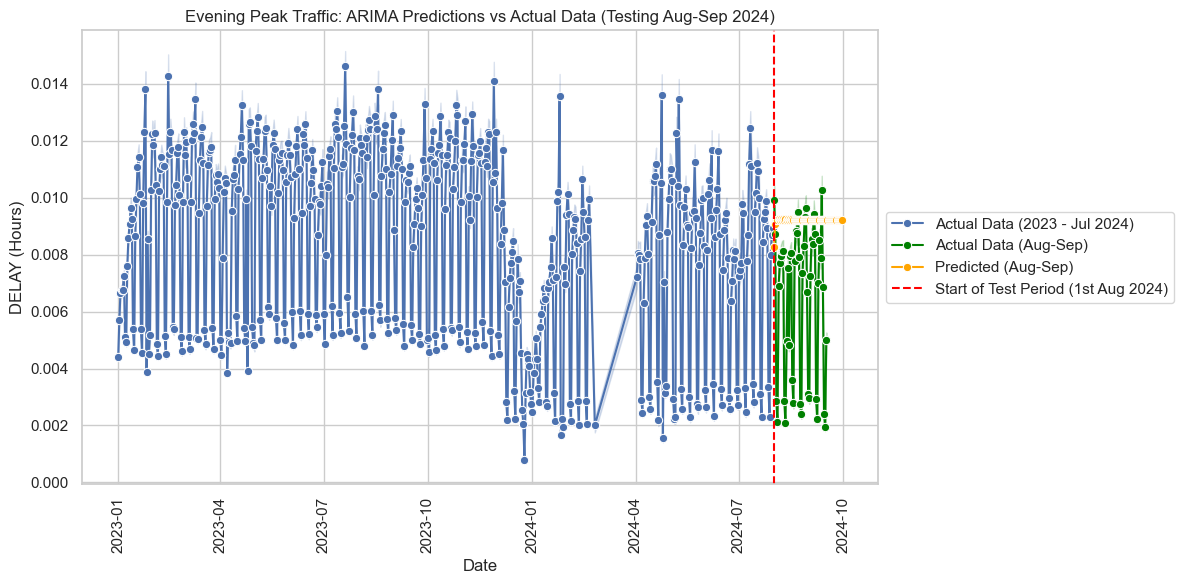

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

# Step 1: Filter the dataset for '3pm-6pm: Evening Peak'
df_filtered = df[df['Categorise Traffic Time'] == '3pm-6pm: Evening Peak'].copy()

# Step 2: Filter the data for training: all data from 2023 to July 2024 (Pre-Trial Data)
df_train = df_filtered[df_filtered['START_DATE'] < '2024-08-01'].copy()

# Convert 'START_DATE' to datetime and set it as the index
df_train['START_DATE'] = pd.to_datetime(df_train['START_DATE'])
df_train.set_index('START_DATE', inplace=True)

# Ensure 'DELAY_HOURS' is numeric and drop NaN values
df_train['DELAY_HOURS'] = pd.to_numeric(df_train['DELAY_HOURS'], errors='coerce')
df_train.dropna(subset=['DELAY_HOURS'], inplace=True)

# Step 3: Fit the ARIMA model on the training data (Pre-Trial Data)
model = ARIMA(df_train['DELAY_HOURS'], order=(2, 1, 2))  # ARIMA(2,1,2) model
model_fit = model.fit()

# Step 4: Forecast the delay hours for August and September (for testing purposes)
forecast_steps_test = 61  # Forecast for 61 days (August + September)
forecast_test = model_fit.get_forecast(steps=forecast_steps_test)
forecast_values_test = forecast_test.predicted_mean

# Step 5: Prepare the dates for testing (August and September 2024)
test_dates = pd.date_range(start='2024-08-01', periods=forecast_steps_test)

# Create a DataFrame for the predicted values during the test period
df_predictions_test = pd.DataFrame({
    'START_DATE': test_dates,
    'DELAY_HOURS': forecast_values_test
})

# Step 6: Filter the actual data for the test period (August to September 2024)
df_test = df_filtered[(df_filtered['START_DATE'] >= '2024-08-01') & (df_filtered['START_DATE'] <= '2024-09-30')].copy()
df_test['START_DATE'] = pd.to_datetime(df_test['START_DATE'])
df_test.set_index('START_DATE', inplace=True)

# Step 7: Plot the results
sns.set(style='whitegrid')

# Plot actual data for training period (2023 to July 2024)
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_train.index, y='DELAY_HOURS', data=df_train, marker="o", label='Actual Data (2023 - Jul 2024)')

# Plot actual data for August to September (test period)
sns.lineplot(x=df_test.index, y='DELAY_HOURS', data=df_test, marker="o", color='green', label='Actual Data (Aug-Sep)')

# Plot the ARIMA predictions for the test period (August to September 2024)
sns.lineplot(x='START_DATE', y='DELAY_HOURS', data=df_predictions_test, marker="o", color='orange', label='Predicted (Aug-Sep)')

# Add a vertical red line at 01/08/2024 (start of predictions)
highlight_date = pd.to_datetime('2024-08-01')
plt.axvline(x=highlight_date, color='red', linestyle='--', label='Start of Test Period (1st Aug 2024)')

# Customise the plot
plt.title('Evening Peak Traffic: ARIMA Predictions vs Actual Data (Testing Aug-Sep 2024)')
plt.xlabel('Date')
plt.ylabel('DELAY (Hours)')
plt.xticks(rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

# Ensure a tight layout
plt.tight_layout()
plt.show()

##### Observations and Limitations: #####
1. Similar to the morning peak observation, the predicted values for the evening peak are much smoother than the actual data. This is an indication that the model may be underfitting the data, as it cannot capture the short-term variations in the actual traffic delays.
2. The ARIMA model’s predictions stay relatively constant, while the actual evening peak delay data (in green) has considerable variance, with many peaks and valleys. The model fails to react to these abrupt changes in traffic delay, suggesting that it’s not capturing some inherent patterns, such as seasonality or external factors causing traffic delays.
3. Given the observations of smoothing and underfitting, we might need to try more sophisticated models, such as SARIMA (Seasonal ARIMA).

***

### Conclusion

In this notebook, we conducted a comprehensive analysis of traffic delay data for the **City of Gold Coast**, focusing on both **Morning Peak (8am-10am)** and **Evening Peak (3pm-6pm)** periods. Our goal was to explore historical traffic delay patterns and predict future traffic delays for the period of August to December 2024 using **Box Plots**, **Linear Regression**, and **ARIMA**.

#### Key Findings:

1. **Box Plot Analysis**:
   - The box plots provided a detailed overview of the distribution and spread of traffic delays across different time periods. 
   - We observed several **outliers**, particularly during peak hours, which indicated significant traffic congestion during certain days. 
   - The median values showed distinct peaks during morning and evening rush hours, confirming consistent patterns of traffic congestion during these times.

2. **Linear Regression**:
   - The linear regression model was applied to predict traffic delays for both morning and evening peaks. The model showed a general upward trend in delays, but its predictive accuracy was limited by the presence of significant fluctuations in the data.
   - **Morning Peak Linear Regression**: The model successfully captured an overall increasing trend in delays from June to July, with reasonable predictions extending to the August-December period.
   - **Evening Peak Linear Regression**: Similar to the morning peak, the model showed reasonable trend predictions but failed to capture short-term fluctuations effectively.

3. **ARIMA Model**:
   - **ARIMA (AutoRegressive Integrated Moving Average)** models were applied to both morning and evening peak periods for predicting traffic delays from August to December 2024.
   - **Morning Peak ARIMA**: The model captured the overall trend but struggled to reflect the short-term volatility seen in actual traffic delay data. Predictions for August to September showed a general smoothing effect, which didn’t align well with the actual peaks and troughs.
   - **Evening Peak ARIMA**: Similar to the morning peak, the evening peak predictions also exhibited smoothing and underfitting. The predicted values failed to capture the spikes and variability seen in actual traffic delays.
   - Both models exhibited narrow confidence intervals, suggesting high certainty in the predictions, but this certainty might be misplaced given the inability to capture the full complexity of the data.

4. **Comparison of Linear Regression and ARIMA**:
   - While both models captured the general trends in the traffic delay data, they failed to account for the high levels of variability and sudden spikes in delays.
   - Linear regression provided a simple trendline prediction, whereas ARIMA allowed for more flexible modeling but resulted in oversmoothing of the predictions.
   - **ARIMA’s complexity** allowed it to model temporal dependencies better, but both models were limited in their ability to reflect the true nature of traffic delay variability, particularly during the testing phase for August and September.

#### Summary of Insights:
- **Morning vs Evening Peak**: Both morning and evening peak traffic exhibited similar patterns of congestion, but the evening peak seemed to have slightly lower delays compared to morning.
- **Model Limitations**: The high variability and frequent peaks in traffic delay make it difficult for traditional models like linear regression and ARIMA to fully capture the complexity of the data. Both models tended to underfit the data by smoothing out the sharp changes in traffic delay.

#### Future Work:
- **Model Tuning and SARIMA**: Future work should involve experimenting with **SARIMA** models to account for seasonality in the data, which might better reflect cyclical patterns in traffic delays.
- **Inclusion of External Factors**: External variables, such as **weather conditions**, **public events**, or **road construction**, could explain some of the unpredictable spikes in traffic delays. Including such factors in future models could improve predictive accuracy.
- **Advanced Machine Learning Models**: Exploring more sophisticated models such as **XGBoost**, **Random Forest**, or **LSTM (Long Short-Term Memory)** networks could better capture nonlinear relationships and provide more accurate short-term predictions.

***